In [1]:
import ibmos2spark
from pyspark.sql.functions import count,countDistinct
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
spark = SparkSession.builder.getOrCreate()
plt.style.use('ggplot')

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'Mah02bEi7GKj9hczaiL-NL7wB1ZrY7LfQx-6-TpVvu3W',
    'service_id': 'iam-ServiceId-b028ce9d-a803-48bc-bdc5-d57d88989644',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_9e785eb379d44200ba4fa10da519fc98_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')
df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load(cos.url('WTFI_APPRX_URL_PROCESSED.csv', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
df.take(5)

[Row(experimentNum=1, runtime=136.2760820388794, thread=1, emitNum=1, estimate=449, item='http://en.wikipedia.org/skins-1.5/common/wikibits.js?99', lowerBound=417, upperBound=449, mapSize=128),
 Row(experimentNum=1, runtime=136.2760820388794, thread=1, emitNum=1, estimate=383, item='http://en.wikipedia.org/w/opensearch_desc.php', lowerBound=351, upperBound=383, mapSize=128),
 Row(experimentNum=1, runtime=136.2760820388794, thread=1, emitNum=1, estimate=373, item='http://en.wikipedia.org/skins-1.5/monobook/user.gif', lowerBound=341, upperBound=373, mapSize=128),
 Row(experimentNum=1, runtime=136.2760820388794, thread=1, emitNum=1, estimate=357, item='http://en.wikipedia.org/skins-1.5/monobook/headbg.jpg', lowerBound=325, upperBound=357, mapSize=128),
 Row(experimentNum=1, runtime=136.2760820388794, thread=1, emitNum=1, estimate=106, item='http://en.wikipedia.org/wiki/Main_Page', lowerBound=74, upperBound=106, mapSize=128)]

In [2]:
schema = StructType([
    StructField("counter", IntegerType(), True),
    StructField("timestamp", StringType(), True),
    StructField("url", StringType(), True),
    StructField("update", StringType(), True)])
exact_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option("delimiter", " ")\
  .option('header', 'false')\
  .schema(schema)\
  .load(cos.url('wiki.gz', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
exact_data.take(5)

[Row(counter=929840853, timestamp='1190146243.326', url='http://upload.wikimedia.org/wikipedia/en/thumb/e/e4/James_Johnson.jpg/200px-James_Johnson.jpg', update='-'),
 Row(counter=929840856, timestamp='1190146243.321', url='http://en.wikipedia.org/images/wiki-en.png', update='-'),
 Row(counter=929840854, timestamp='1190146243.311', url='http://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Flag_of_Australia.svg/22px-Flag_of_Australia.svg.png', update='-'),
 Row(counter=929840855, timestamp='1190146243.301', url='http://es.wikipedia.org/w/index.php?title=-&action=raw&gen=js&useskin=monobook', update='-'),
 Row(counter=929840857, timestamp='1190146243.303', url='http://en.wikipedia.org/w/index.php?title=MediaWiki:Monobook.css&usemsgcache=yes&action=raw&ctype=text/css&smaxage=2678400', update='-')]

In [3]:
df.createOrReplaceTempView("results")
max_emit_num = spark.sql("SELECT item,MAX(emitNum) as emitNum FROM results GROUP BY item")
gr = exact_data.groupBy("url").agg(count("url").alias('count')).orderBy('count',ascending=False)
gr.show()

+--------------------+-------+
|                 url|  count|
+--------------------+-------+
|http://upload.wik...|1349594|
|http://meta.wikim...|1129027|
|http://en.wikiped...| 970038|
|http://en.wikiped...| 968040|
|http://en.wikiped...| 966725|
|http://en.wikiped...| 902376|
|http://en.wikiped...| 744669|
|http://en.wikiped...| 739240|
|http://en.wikiped...| 731365|
|http://en.wikiped...| 727820|
|http://en.wikiped...| 725208|
|http://en.wikiped...| 718798|
|http://en.wikiped...| 703640|
|http://en.wikiped...| 644653|
|http://en.wikiped...| 642872|
|http://en.wikiped...| 634137|
|http://en.wikiped...| 625130|
|http://en.wikiped...| 622010|
|http://en.wikiped...| 596438|
|http://en.wikiped...| 526255|
+--------------------+-------+
only showing top 20 rows



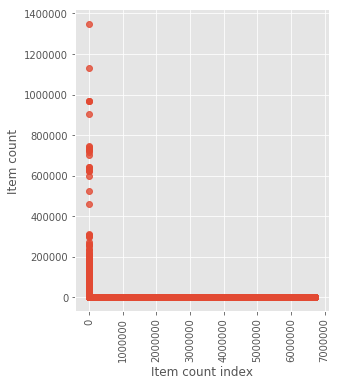

In [33]:
df_counts = gr.select('count').orderBy('count',ascending=False).toPandas()
ax = sns.lmplot( x="index", y="count", data=df_counts.reset_index(), fit_reg=False)
plt.xticks(rotation=90)
plt.xlabel('Item count index')
# Set y-axis label
plt.ylabel('Item count')
plt.show()

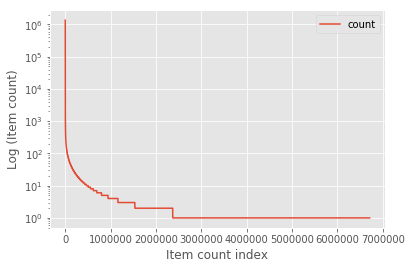

In [34]:
ax = df_counts.plot(logy=True, logx=False)
plt.xlabel('Item count index')
# Set y-axis label
plt.rcParams["figure.figsize"] =(9,9)
plt.ylabel('Log (Item count)')
plt.show()

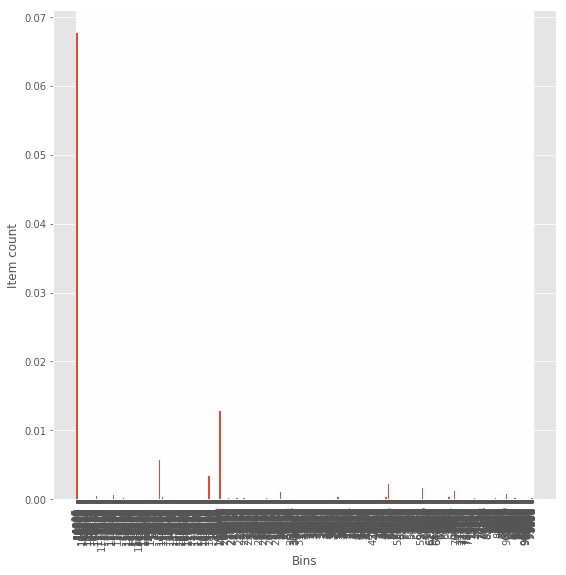

In [29]:
ax = plt.hist(df_counts, bins='auto',normed=True)
plt.xticks(rotation=90)
plt.xlabel('Bins')
plt.ylabel('Item count')
plt.show()

In [7]:
distinct_keys = exact_data.agg(countDistinct("url"))
distinct_keys.show()

+-------------------+
|count(DISTINCT url)|
+-------------------+
|            6708723|
+-------------------+



In [23]:
exact_data.count()

79093443

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


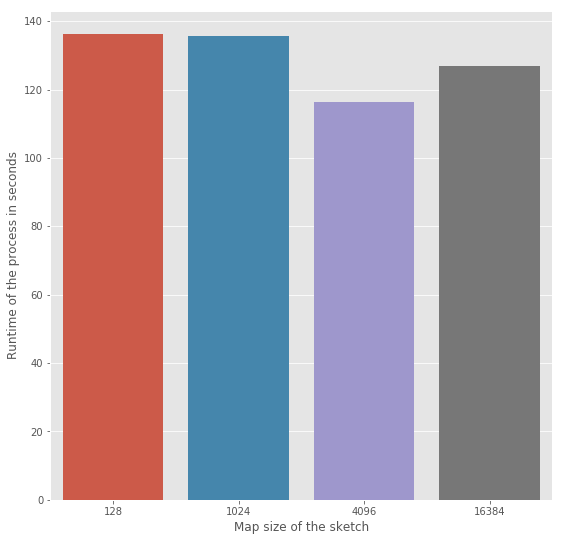

In [8]:
runtime = df.select('mapSize','runtime').distinct()
df_runtime = runtime.toPandas()
ax = sns.barplot( x="mapSize", y="runtime", data=df_runtime)
plt.xlabel('Map size of the sketch')
# Set y-axis label
plt.ylabel('Runtime of the process in seconds')
plt.show()

In [ ]:
experiment1 = df.filter(df['experimentNum'] == 1)
experiment1.createOrReplaceTempView("experiment1")
experiment1 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment1 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment1 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare1 = experiment1.join(gr, experiment1.item == gr.url)
df_compare1.createOrReplaceTempView("df_compare1")
diff1 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, ((ABS(count - estimate)/ count) * 100) as diff_percent, round((100.0*ABS(estimate - count)) / count,3)as diff_percent_old ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare1 ORDER BY count DESC')
diff1.show()


In [10]:
diff1.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-------------------+--------------------+------------------+-------------------+
|summary|               diff|        diff_percent|         diffLower|          diffUpper|
+-------+-------------------+--------------------+------------------+-------------------+
|  count|                137|                 137|               137|                137|
|   mean|-3913.4160583941607|11.75086131386861...|-43132.69343065693|-3913.4160583941607|
| stddev| 13458.169000561757|  26.543170347119673| 7208.804124494171| 13458.169000561757|
|    min|             -82114|               0.000|            -82196|             -82114|
|    max|              20643|              99.790|            -18502|              20643|
+-------+-------------------+--------------------+------------------+-------------------+



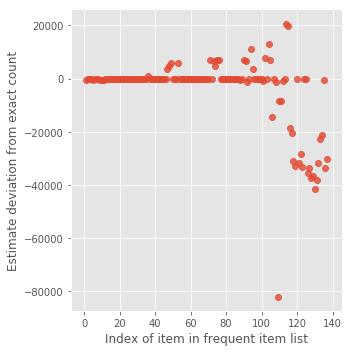

In [11]:
pd_diff1 = diff1.toPandas()
pd_diff1['s_index'] = range(1, len(pd_diff1) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff1, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [12]:
experiment2 = df.filter(df['experimentNum'] == 2)
experiment2.createOrReplaceTempView("experiment2")
experiment2 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment2 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment2 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare2 = experiment2.join(gr, experiment2.item == gr.url)
df_compare2.createOrReplaceTempView("df_compare2")
diff2 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare2 ORDER BY count DESC')
diff2.show()

+-------+--------------------+--------+----------+----------+-------+----+------------+---------+---------+
|mapSize|                item|estimate|lowerBound|upperBound|  count|diff|diff_percent|diffLower|diffUpper|
+-------+--------------------+--------+----------+----------+-------+----+------------+---------+---------+
|   1024|http://upload.wik...| 1349131|   1344582|   1349131|1349594|-463|       0.034|    -5012|     -463|
|   1024|http://meta.wikim...| 1128886|   1124416|   1128886|1129027|-141|       0.012|    -4611|     -141|
|   1024|http://en.wikiped...|  969715|    965308|    969715| 970038|-323|       0.033|    -4730|     -323|
|   1024|http://en.wikiped...|  967716|    963309|    967716| 968040|-324|       0.033|    -4731|     -324|
|   1024|http://en.wikiped...|  966191|    961871|    966191| 966725|-534|       0.055|    -4854|     -534|
|   1024|http://en.wikiped...|  902376|    898453|    902376| 902376|   0|       0.000|    -3923|        0|
|   1024|http://en.wikiped..

In [13]:
diff2.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-------------------+--------------------+------------------+-------------------+
|summary|               diff|        diff_percent|         diffLower|          diffUpper|
+-------+-------------------+--------------------+------------------+-------------------+
|  count|               1119|                1119|              1119|               1119|
|   mean|-1534.6541554959786|41.77728418230563...|-3945.502234137623|-1534.6541554959786|
| stddev|  2086.183750218654|   46.16356047285539|1374.4709327704174|  2086.183750218654|
|    min|              -8890|               0.000|             -8897|              -8890|
|    max|               3218|             100.000|                 0|               3218|
+-------+-------------------+--------------------+------------------+-------------------+



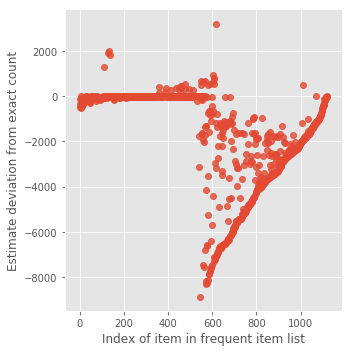

In [14]:
pd_diff2 = diff2.toPandas()
pd_diff2['s_index'] = range(1, len(pd_diff2) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff2, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [15]:
experiment3 = df.filter(df['experimentNum'] == 3)
experiment3.createOrReplaceTempView("experiment3")
experiment3 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment3 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment3 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare3 = experiment3.join(gr, experiment3.item == gr.url)
df_compare3.createOrReplaceTempView("df_compare3")
diff3 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare3 ORDER BY count DESC')
diff3.show()

+-------+--------------------+--------+----------+----------+-------+----+------------+---------+---------+
|mapSize|                item|estimate|lowerBound|upperBound|  count|diff|diff_percent|diffLower|diffUpper|
+-------+--------------------+--------+----------+----------+-------+----+------------+---------+---------+
|   4096|http://upload.wik...| 1349131|   1348147|   1349131|1349594|-463|       0.034|    -1447|     -463|
|   4096|http://meta.wikim...| 1128886|   1127916|   1128886|1129027|-141|       0.012|    -1111|     -141|
|   4096|http://en.wikiped...|  969715|    968744|    969715| 970038|-323|       0.033|    -1294|     -323|
|   4096|http://en.wikiped...|  967716|    966745|    967716| 968040|-324|       0.033|    -1295|     -324|
|   4096|http://en.wikiped...|  966191|    965235|    966191| 966725|-534|       0.055|    -1490|     -534|
|   4096|http://en.wikiped...|  902376|    901507|    902376| 902376|   0|       0.000|     -869|        0|
|   4096|http://en.wikiped..

In [16]:
diff3.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+------------------+--------------------+-------------------+------------------+
|summary|              diff|        diff_percent|          diffLower|         diffUpper|
+-------+------------------+--------------------+-------------------+------------------+
|  count|             44262|               44262|              44262|             44262|
|   mean|-99.09852695314265|76.15395734490081...|-141.85021011251186|-99.09852695314265|
| stddev|209.01329188701007|   34.61266134500764| 272.37709265977935|209.01329188701007|
|    min|             -1914|               0.000|              -1914|             -1914|
|    max|               809|             100.000|                  0|               809|
+-------+------------------+--------------------+-------------------+------------------+



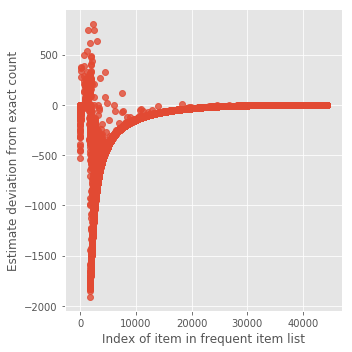

In [17]:
pd_diff3 = diff3.toPandas()
pd_diff3['s_index'] = range(1, len(pd_diff3) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff3, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [4]:
experiment4 = df.filter(df['experimentNum'] == 4)
experiment4.createOrReplaceTempView("experiment4")
experiment4 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment4 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment4 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare4 = experiment4.join(gr, experiment4.item == gr.url)
df_compare4.createOrReplaceTempView("df_compare4")
diff4 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare4 ORDER BY count DESC')
diff4.show()

+-------+--------------------+--------+----------+----------+-------+----+------------+---------+---------+
|mapSize|                item|estimate|lowerBound|upperBound|  count|diff|diff_percent|diffLower|diffUpper|
+-------+--------------------+--------+----------+----------+-------+----+------------+---------+---------+
|  16384|http://upload.wik...| 1349131|   1348917|   1349131|1349594|-463|       0.034|     -677|     -463|
|  16384|http://meta.wikim...| 1128886|   1128674|   1128886|1129027|-141|       0.012|     -353|     -141|
|  16384|http://en.wikiped...|  969715|    969503|    969715| 970038|-323|       0.033|     -535|     -323|
|  16384|http://en.wikiped...|  967716|    967504|    967716| 968040|-324|       0.033|     -536|     -324|
|  16384|http://en.wikiped...|  966191|    965981|    966191| 966725|-534|       0.055|     -744|     -534|
|  16384|http://en.wikiped...|  902376|    902186|    902376| 902376|   0|       0.000|     -190|        0|
|  16384|http://en.wikiped..

In [5]:
diff4.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+------------------+--------------------+-------------------+------------------+
|summary|              diff|        diff_percent|          diffLower|         diffUpper|
+-------+------------------+--------------------+-------------------+------------------+
|  count|            246697|              246697|             246697|            246697|
|   mean|-33.82309878109584|71.67811213350790...|-41.363267490078925|-33.82309878109584|
| stddev| 56.71614898327473|   35.34997085823117|  64.81495614919625| 56.71614898327473|
|    min|              -534|               0.000|               -744|              -534|
|    max|               191|             100.000|                  0|               191|
+-------+------------------+--------------------+-------------------+------------------+



Text(0,0.5,'Estimate deviation from exact count')

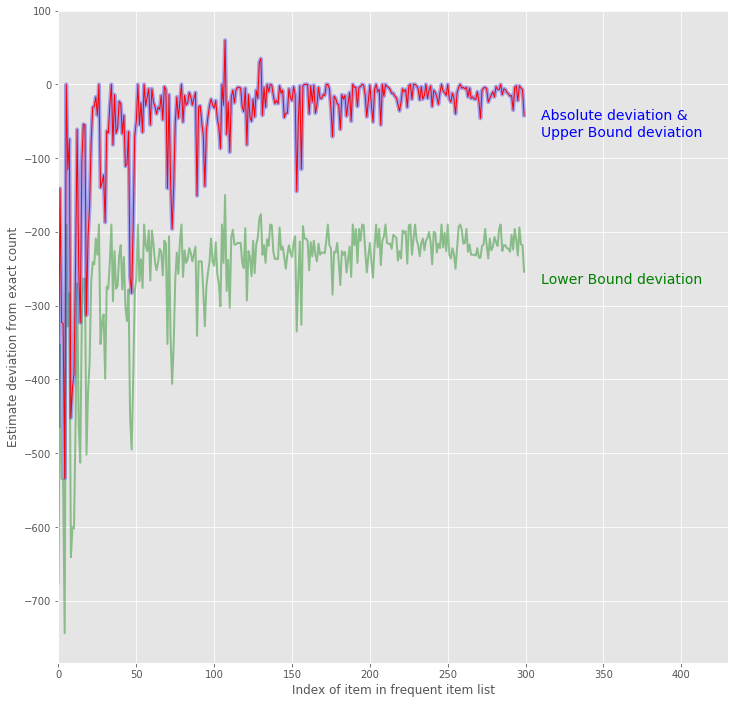

In [41]:
pd_diff4 = diff4.toPandas().head(300)
fig = plt.figure()
ax = plt.axes()
#plt.rcParams["figure.figsize"] =(12,12)
plt.plot(pd_diff4['diffLower'], marker='', color='green', linewidth=2, alpha=0.4)
plt.plot(pd_diff4['diff'], marker='', color='blue', linewidth=4, alpha=0.3)
plt.plot(pd_diff4['diffUpper'], marker='', color='red', linewidth=1, alpha=1)
plt.xlim(0,430)
plt.text(310,-70, 'Absolute deviation &\nUpper Bound deviation', horizontalalignment='left', fontsize=14, color='blue')
plt.text(310,-270, 'Lower Bound deviation', horizontalalignment='left', fontsize=14, color='green')
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')

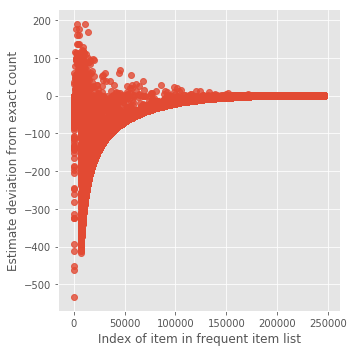

In [20]:
pd_diff4 = diff4.toPandas()
pd_diff4['s_index'] = range(1, len(pd_diff4) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff4, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [ ]:
pd_diff4 = diff4.toPandas()
pd_diff4['s_index'] = range(1, len(pd_diff4) + 1)
ax = sns.lmplot( x="s_index", y="diff_percent", data=pd_diff4, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

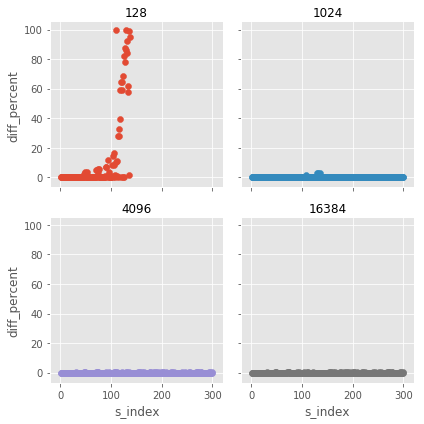

In [21]:
head = 300
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()

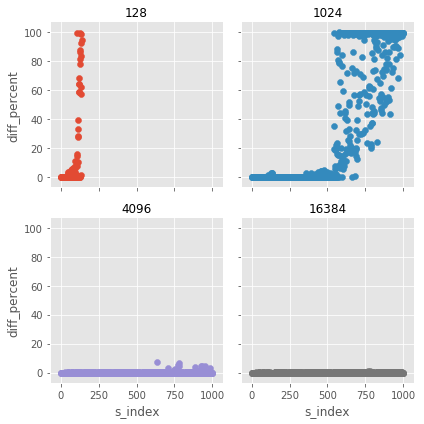

In [22]:
head = 1000
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()

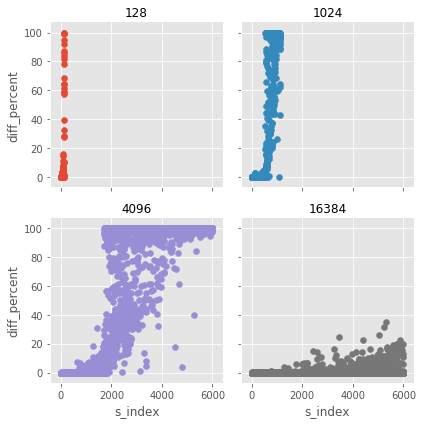

In [25]:
head = 6000
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()

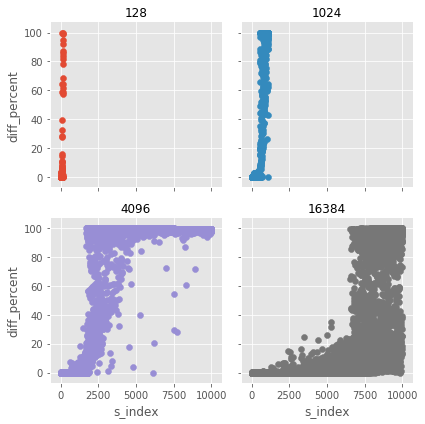

In [24]:
head = 10000
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()